In [ ]:
import sys, os, distutils.core
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os

# Define the path to your "detr" folder
detr_folder_path = '/content/gdrive/My Drive/detr/Nov_2nd'

# Change the current directory to the "detr" folder
os.chdir(detr_folder_path)

In [ ]:
!nvidia-smi

Tue Nov  7 13:53:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content/gdrive/My Drive/detr/Nov_2nd


## Environment setup

In [ ]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 k

In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
roboflow: 1.1.9 ; supervision: 0.3.0 ; transformers: 4.35.0 ; pytorch_lightning: 2.1.0


## loading dataset using roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="2OsTOLKc6WoGIISlKkST")
project = rf.workspace("sjsu-ri0ao").project("new-vky75")
dataset = project.version(1).download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to new-1 in coco-segmentation:: 100%|██████████| 6522/6522 [1:52:22<00:00,  1.03s/it]


## Creating COCO loader

In [ ]:
import os
import torchvision
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset.location, "train")
VAL_DIRECTORY = os.path.join(dataset.location, "valid")
TEST_DIRECTORY = os.path.join(dataset.location, "test")

# Create an instance of DetrImageProcessor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 5689
Number of validation examples: 546
Number of test examples: 279


In [ ]:
# to see the no of class in my dataset:
import json
import os

# Define the path to your annotation file
annotation_file_path = os.path.join(TRAIN_DIRECTORY, ANNOTATION_FILE_NAME)

# Load the annotations
with open(annotation_file_path, 'r') as f:
    annotations = json.load(f)

# Extract and print categories
categories = annotations['categories']
print("Number of classes:", len(categories))
print("Classes:")
for category in categories:
    print(f"ID: {category['id']}, Name: {category['name']}")



Number of classes: 33
Classes:
ID: 0, Name: Amenities
ID: 1, Name: B-Hoop
ID: 2, Name: BBQ
ID: 3, Name: Bathtub
ID: 4, Name: Billiards table
ID: 5, Name: Blender
ID: 6, Name: Chair
ID: 7, Name: Coffemaker
ID: 8, Name: Couch
ID: 9, Name: Crib
ID: 10, Name: Dish Washer
ID: 11, Name: Fireplace
ID: 12, Name: Hair dryer
ID: 13, Name: Jacuzzi
ID: 14, Name: LoungerChaise
ID: 15, Name: Microwave
ID: 16, Name: Refrigerator
ID: 17, Name: Shower
ID: 18, Name: Stand Mixer
ID: 19, Name: Stove
ID: 20, Name: Swimming_Pool
ID: 21, Name: Table
ID: 22, Name: Toaster
ID: 23, Name: Umbrella
ID: 24, Name: baking oven
ID: 25, Name: bed
ID: 26, Name: bed side table
ID: 27, Name: dresser
ID: 28, Name: foosball table
ID: 29, Name: sink
ID: 30, Name: table lamp
ID: 31, Name: television
ID: 32, Name: wall clock


Image #1656


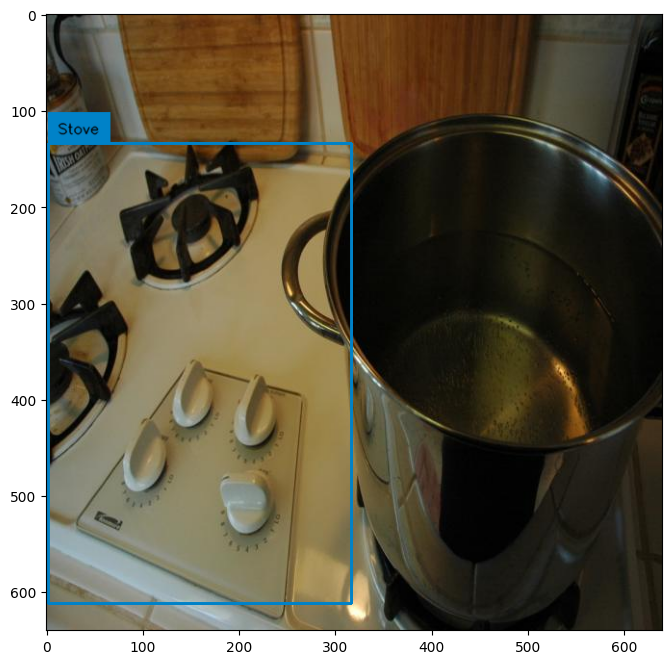

In [ ]:
# Visualize if dataset is loaded properly

import random
import cv2
import numpy as np
import supervision as sv



# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (8, 8))

In [ ]:

from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=16, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=16)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=16)

## Train model with PyTorch Lightning

In [ ]:

import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.train_losses.append(loss.item())
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.val_losses.append(loss.item())
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install torchmetrics


In [ ]:

CHECKPOINT = "facebook/detr-resnet-50"

model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:


from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 20

# Define a TensorBoard logger
logger = TensorBoardLogger("tb_logs", name="my_model")

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='validation/loss',  # Monitor the validation loss
    dirpath='model_checkpoints',  # Directory to save the checkpoints
    filename='best-model-{epoch:02d}-{validation_loss:.2f}',  # Filename for the checkpoints with epoch number and validation loss
    save_top_k=1,  # Only save the top 1 models
    mode='min'  # Minimize the monitored quantity (validation loss in this case)
)

# Define the trainer with the ModelCheckpoint callback and the logger
trainer = Trainer(
    devices=1,
    accelerator="gpu",
    max_epochs=MAX_EPOCHS,
    gradient_clip_val=0.1,
    accumulate_grad_batches=8,
    log_every_n_steps=5,
    callbacks=[checkpoint_callback],
    logger=logger
)

trainer.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /content/gdrive/MyDrive/detr/Nov_2nd/model_checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py", line 44, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py", line 581, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py", line 990, in _run
    results = self._run_stage()
  File "/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py", line 1036, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py", line 202, in run
    self.advance()
  File "/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py", line 359, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/training_epoch_loop.py", line 137

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

In [ ]:
print(f"Number of training batches: {len(model.train_dataloader())}")
print(f"Number of validation batches: {len(model.val_dataloader())}")

Number of training batches: 356
Number of validation batches: 35


Mean of empty slice.
invalid value encountered in double_scalars


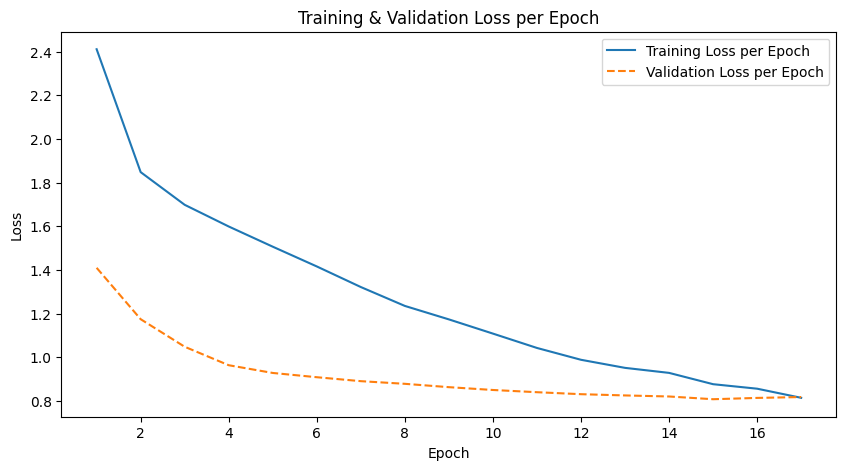

In [ ]:
# Adjusting the second snippet to access the losses from the model object
epoch_train_losses = [np.mean(model.train_losses[i * 356:(i + 1) * 356]) for i in range(50)]
epoch_val_losses = [np.mean(model.val_losses[i * 35:(i + 1) * 135]) for i in range(50)]


# Now plot these
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), epoch_train_losses, label='Training Loss per Epoch')
plt.plot(range(1, 51), epoch_val_losses, label='Validation Loss per Epoch', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss per Epoch')
plt.show()

## model evaluation

Image #89


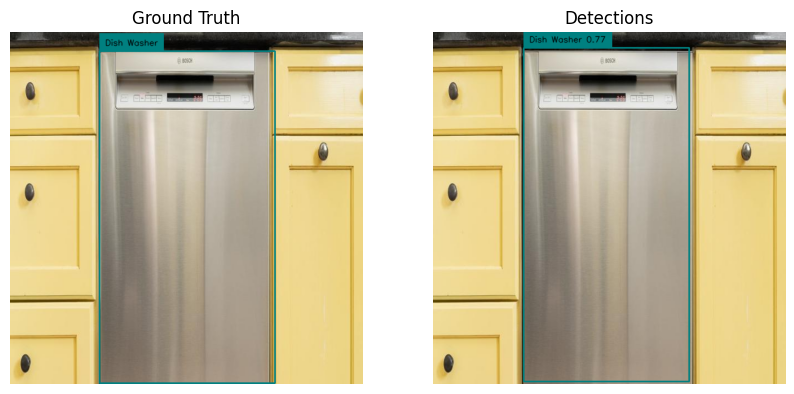

In [ ]:
#Inference on test dataset
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

CONFIDENCE_TRESHOLD = 0.2
# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)




# Annotate detections
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]


    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)



# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()

In [ ]:
#evaluation:
!pip install -q coco_eval
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
print(TEST_DATASET.coco.dataset.keys())


dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [ ]:

from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
import numpy as np
import torch

# Initialize the COCO evaluator
evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])
print("Running evaluation...")

# Evaluation loop
for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    # Move input data to the device
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    # Forward pass, no gradient computation
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # Debugging: Print raw model outputs
    print("Raw model outputs:", outputs)

    # Post-process the raw outputs
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    # Prepare the predictions for COCO evaluation
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)

    # Debugging: Print formatted predictions
    print("Formatted predictions:", predictions)

    # Update the evaluator with the predictions
    if predictions:
        evaluator.update(predictions)
    else:
        print(f"No predictions for batch {idx}")



# Finalize the evaluation
if evaluator.coco_eval:
    evaluator.synchronize_between_processes()
    evaluator.accumulate()
    evaluator.summarize()

    # Accessing COCO evaluation stats
    coco_stats = evaluator.coco_eval['bbox'].stats

    # Explicitly print AP and AR values
    ap_iou_50 = coco_stats[1]  # AP at IoU=0.5
    ap_iou_95 = coco_stats[2]  # AP at IoU=0.95
    map = coco_stats[0]  # mAP
    ar_1 = coco_stats[8]  # AR at maxDets=1
    ar_10 = coco_stats[9]  # AR at maxDets=10
    ar_100 = coco_stats[10]  # AR at maxDets=100
    ar_small = coco_stats[11]  # AR for small objects at maxDets=100
    ar_medium = coco_stats[12]  # AR for medium objects at maxDets=100
    ar_large = coco_stats[13]  # AR for large objects at maxDets=100

    print(f"AP at IoU=0.5: {ap_iou_50:.3f}")
    print(f"AP at IoU=0.95: {ap_iou_95:.3f}")
    print(f"Mean Average Precision (mAP): {map:.3f}")
    print(f"Average Recall (AR) at maxDets=1: {ar_1:.3f}")
    print(f"Average Recall (AR) at maxDets=10: {ar_10:.3f}")
    print(f"Average Recall (AR) at maxDets=100: {ar_100:.3f}")
    print(f"Average Recall (AR) for small objects at maxDets=100: {ar_small:.3f}")
    print(f"Average Recall (AR) for medium objects at maxDets=100: {ar_medium:.3f}")
    print(f"Average Recall (AR) for large objects at maxDets=100: {ar_large:.3f}")
else:
    print("No predictions to evaluate.")



Running evaluation...


  0%|          | 0/18 [00:00<?, ?it/s]

Raw model outputs: DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-3.8253e+00, -1.5280e+00, -2.5038e+00,  ..., -1.7266e+00,
          -1.5112e+00,  9.3125e+00],
         [-4.0847e+00, -6.0978e-01, -1.9639e+00,  ..., -9.3581e-01,
          -7.1105e-01,  7.1826e+00],
         [-3.7795e+00, -6.5379e-01, -2.3632e+00,  ..., -1.7773e+00,
          -1.9113e+00,  8.1196e+00],
         ...,
         [-3.9676e+00, -9.5732e-01, -1.9359e+00,  ..., -1.0498e+00,
          -4.8156e-01,  7.7786e+00],
         [-4.1761e+00, -9.9916e-01, -1.8659e+00,  ..., -2.4952e+00,
          -2.2765e+00,  8.8827e+00],
         [-4.0028e+00, -8.2055e-01, -1.9693e+00,  ..., -8.9087e-01,
          -1.0997e+00,  7.0092e+00]],

        [[-3.7040e+00, -1.4206e+00, -1.4026e+00,  ..., -2.2752e-01,
          -1.1070e+00,  7.7454e+00],
         [-3.7525e+00, -6.4155e-01, -1.5599e-01,  ..., -1.5853e+00,
          -4.7787e-01,  5.9534e+00],
         [-3.9054e+00, -4.9787e-01, -9.7115e-01,  ..., -2.9060e+0

IndexError: ignored

In [ ]:
# COCO evaluation results
coco_stats = evaluator.coco_eval['bbox'].stats

# AP (Average Precision) values
ap_50_95 = coco_stats[0]  # AP at IoU=0.50:0.95
ap_50 = coco_stats[1]  # AP at IoU=0.50
ap_75 = coco_stats[2]  # AP at IoU=0.75
ap_small = coco_stats[3]  # AP for small objects at IoU=0.50:0.95
ap_medium = coco_stats[4]  # AP for medium objects at IoU=0.50:0.95
ap_large = coco_stats[5]  # AP for large objects at IoU=0.50:0.95

# AR (Average Recall) values
ar_1 = coco_stats[6]  # AR at maxDets=1
ar_10 = coco_stats[7]  # AR at maxDets=10
ar_100 = coco_stats[8]  # AR at maxDets=100
ar_small = coco_stats[9]  # AR for small objects at maxDets=100
ar_medium = coco_stats[10]  # AR for medium objects at maxDets=100
ar_large = coco_stats[11]  # AR for large objects at maxDets=100

print("Average Precision (AP) at IOU=0.50:0.95:", ap_50_95)
print("Average Precision (AP) at IOU=0.50:", ap_50)
print("Average Precision (AP) at IOU=0.75:", ap_75)
print("Average Precision (AP) for small objects:", ap_small)
print("Average Precision (AP) for medium objects:", ap_medium)
print("Average Precision (AP) for large objects:", ap_large)

print("Average Recall (AR) at maxDets=1:", ar_1)
print("Average Recall (AR) at maxDets=10:", ar_10)
print("Average Recall (AR) at maxDets=100:", ar_100)
print("Average Recall (AR) for small objects:", ar_small)
print("Average Recall (AR) for medium objects:", ar_medium)
print("Average Recall (AR) for large objects:", ar_large)

Average Precision (AP) at IOU=0.50:0.95: 0.3286882213612663
Average Precision (AP) at IOU=0.50: 0.43542760137668945
Average Precision (AP) at IOU=0.75: 0.3646845382027592
Average Precision (AP) for small objects: 0.0
Average Precision (AP) for medium objects: 0.14343332318579843
Average Precision (AP) for large objects: 0.37553794988154293
Average Recall (AR) at maxDets=1: 0.3734503491211465
Average Recall (AR) at maxDets=10: 0.412331708543993
Average Recall (AR) at maxDets=100: 0.4129229247602092
Average Recall (AR) for small objects: 0.0
Average Recall (AR) for medium objects: 0.1733068783068783
Average Recall (AR) for large objects: 0.4639832096634341


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------